In [2]:
# Importing libraries
import time, psutil, os, math
from tqdm.contrib import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

/home/shleekshu/miniconda3/envs/fairtest/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

**Classification.** In [statistics](https://en.wikipedia.org/wiki/Statistics) and [machine learning](https://en.wikipedia.org/wiki/Machine_learning), [classification](https://en.wikipedia.org/wiki/Statistical_classification) refers to a type of [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning). For this task, training data with known class labels are given and is used to develop a [classification rule](https://en.wikipedia.org/wiki/Classification_rule) for assigning new unlabeled data to one of the classes. A special case of the task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), which involves only two classes. Some examples:

- Classifying an email as `spam` or `non-spam`
- Classifying a tumor as `benign` or `malignant`

The algorithms that sort unlabeled data into labeled classes are called *classifiers*. Loosely speaking, the [sorting hat](https://en.wikipedia.org/wiki/Magical_objects_in_Harry_Potter#Sorting_Hat) from [Hogwarts](https://en.wikipedia.org/wiki/Hogwarts) can be thought of as a classifier that sorts incoming students into four distinct houses. In real life, some common classifiers are [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning), [random forest](https://en.wikipedia.org/wiki/Random_forest), [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine), [naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), [linear discriminant analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis), [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), [XGBoost](https://en.wikipedia.org/wiki/XGBoost), [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) and [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network).


# Logistic Function


We use [logistic function](https://en.wikipedia.org/wiki/Logistic_function) (sometimes simply referred to as the *sigmoid*), which is given by

$$ g(x) = \frac{1}{1+e^{-x}}, $$

for $x \in \mathbb{R}$. The next two code blocks construct and plot this function.

In [3]:
# Logistic function
def logistic(x):
    """
    Computes the logistic function applied to an input scalar/array
    Args:
        x (scalar/ndarray): scalar or numpy array of any size
    Returns:
        y (scalar/ndarray): logistic function applied to x, has the same shape as x
    """
    y = 1 / (1 + np.exp(-x))
    return y

x, x_arr = 0, np.array([-5, -1, 1, 5])
print(f"logistic({x}) = {logistic(x)}")
print(f"logistic({x_arr}) = {logistic(x_arr)}")

logistic(0) = 0.5
logistic([-5 -1  1  5]) = [0.00669285 0.26894142 0.73105858 0.99330715]


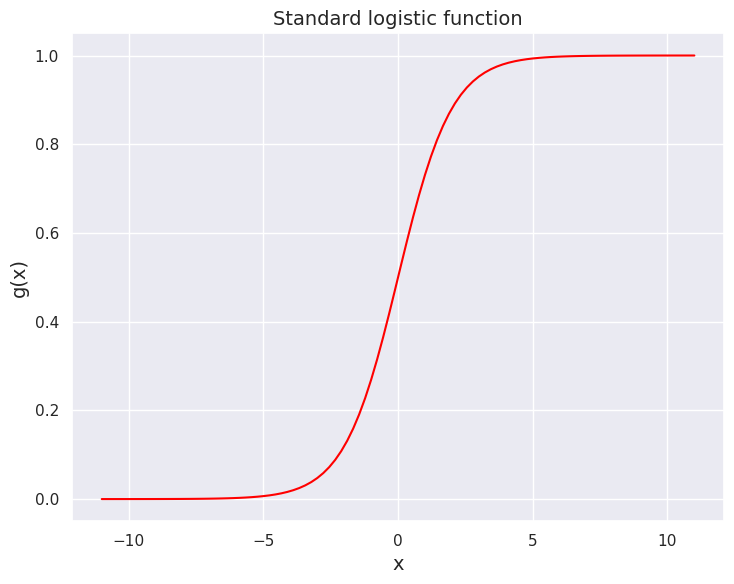

In [4]:
# Plotting the logistic function
plt.figure(figsize = (7.5, 6))
x = np.linspace(-11, 11, 100)
plt.plot(x, logistic(x), color = 'red')
plt.xlabel("x", fontsize = 14)
plt.ylabel("g(x)", fontsize = 14)
plt.title("Standard logistic function", fontsize = 14)
plt.tight_layout()
plt.show()

# Log Loss

The `loss function`, which corresponds to the *true value* and *predicted value* of a single observation. The `cost function` can be thought of as *expected loss* or *average loss* over a group of observations. Contrary to linear regression, which employs `squared loss`, logistic regression makes use of the `log loss` function, given by

$$ L(y, y') = -y \log\left(y'\right) - \left(1 - y\right) \log\left(1 - y'\right), $$

where $y$ is the true value of a binary target (taking values $0$ or $1$) and $y'$ is the prediction, which can be thought of as the predicted probability of $y$ being $1$. Observe that the loss is $0$, when the true value and predicted value agree with each other, i.e. $L(0, 0) = L(1, 1) = 0$. On the other hand, the loss explodes towards infinity if the predicted value approaches $1$ when the true value is $0$, or it approaches $0$ when the true value is $1$. In the next couple of code blocks, we construct the function to compute log loss and plot it for $y = 0$ and $y = 1$. Since the true values (labels) are always $0$ or $1$, we do not need to pay heed to the behaviour of the function $L$ for other values of $y$.

In [5]:
# Log loss
def log_loss(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (scalar): true value (0 or 1)
      y_dash (scalar): predicted value (probability of y being 1)
    Returns:
      loss (float): nonnegative loss corresponding to y and y_dash
    """
    loss = - (y * np.log(y_dash)) - ((1 - y) * np.log(1 - y_dash))
    return loss

y, y_dash = 0, 0.6
print(f"log_loss({y}, {y_dash}) = {log_loss(y, y_dash)}")

log_loss(0, 0.6) = 0.916290731874155


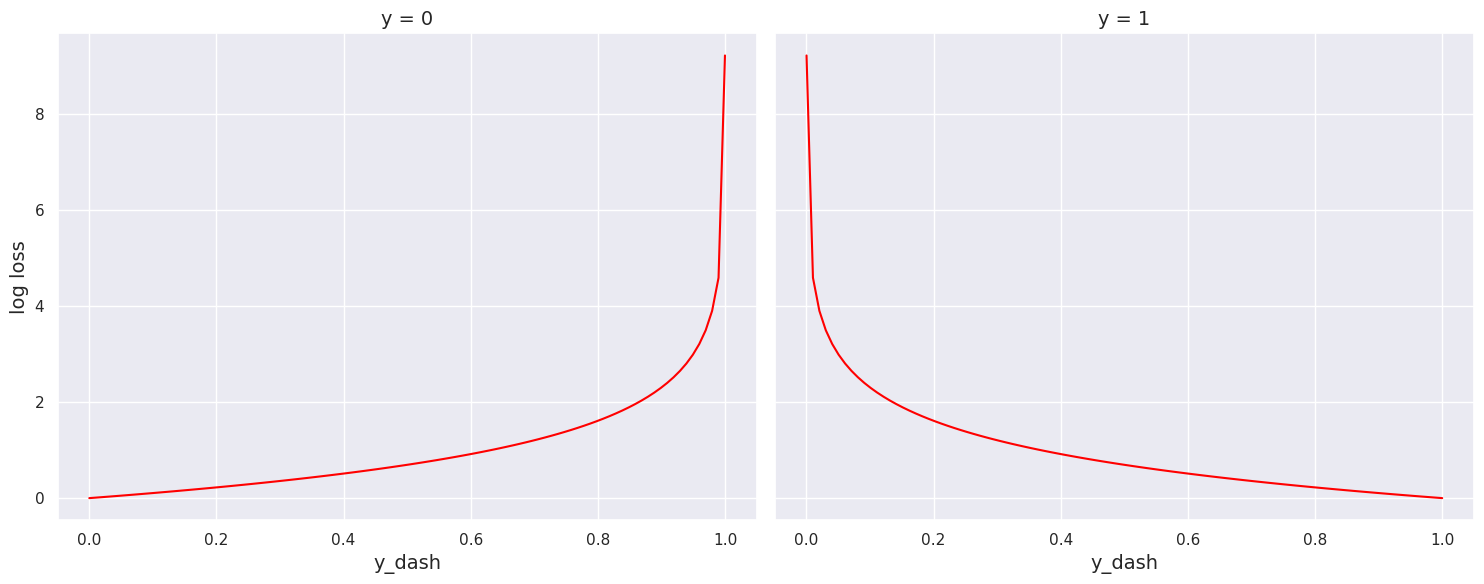

In [6]:
# Log loss for y = 0 and y = 1
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)
y_dash = np.linspace(0.0001, 0.9999, 100)
ax[0].plot(y_dash, log_loss(0, y_dash), color = 'red')
ax[0].set_title("y = 0", fontsize = 14)
ax[0].set_xlabel("y_dash", fontsize = 14)
ax[0].set_ylabel("log loss", fontsize = 14)
ax[1].plot(y_dash, log_loss(1, y_dash), color = 'red')
ax[1].set_title("y = 1", fontsize = 14)
ax[1].set_xlabel("y_dash", fontsize = 14)
plt.tight_layout()
plt.show()

The plots sync with the intuition that loss should be minimum when the predicted value (probability) matches the true value $(0$ or $1)$, and should increase as the two values drift apart.

# Cost Function

Let $\mathbf{y} = (y_1, y_2, \cdots, y_n)$ be the true values $(0$ or $1)$ and $\mathbf{y'} = (y_1', y_2', \cdots, y_n')$ be the corresponding predictions (probabilities). Then, the *cost function* is given by the average loss:

$$ C(\mathbf{y}, \mathbf{y'}) = \frac{1}{m}\sum_{i = 1}^m L(y_i, y_i'). $$

We construct the function to compute cost in the following two code blocks. An important structural distinction from the log loss function is that here the arguments `y` and `y_dash` are vectors, not scalars.

In [9]:
# Cost function - using vectorization
def cost_func_vec(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    loss_vec = np.array([log_loss(y[i], y_dash[i]) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    return cost

y, y_dash = np.array([0, 1, 0]), np.array([0.4, 0.6, 0.25])
print(cost_func_vec(y, y_dash))

0.43644443999458743


Let us assume that we want to predict $y$ based on $n$ features. In this setup, a logistic regression model is characterized by $n+1$ parameters:

- weight parameters $\mathbf{w} = (w_1, w_2, \cdots, w_n)$
- bias parameter $b$

Note that, the [dot product](https://en.wikipedia.org/wiki/Dot_product) of two vectors $\mathbf{a} = (a_1, a_2, \cdots, a_n)$ and $\mathbf{b} = (b_1, b_2, \cdots, b_n)$ is given by $\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^n a_ib_i$. It is a scalar value and evidently, $\mathbf{a} \cdot \mathbf{b} = \mathbf{b} \cdot \mathbf{a}$. Given the realized values of $n$ features $\mathbf{x} = (x_1, x_2, \cdots, x_n)$, the model feeds $\mathbf{x} \cdot \mathbf{w} + b$ to the logistic function $g$, and projects the output as the predicted probability of $y = 1$. Concretely, we have

$$ y' = g\left(\mathbf{x} \cdot \mathbf{w} + b\right) = \frac{1}{1 + e^{-\left(\mathbf{x} \cdot \mathbf{w} + b\right)}}. \tag{1} $$

Let us consider the situation of $m$ observations, with the $i$th observation having feature values $\mathbf{x_i} = (x_{i,1}, x_{i,2}, \cdots, x_{i,n})$, true target value $y_i$ and predicted probabilities $y_i' = g\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)$. Stacking them up, we obtain the feature matrix $\mathbf{X}$, target vector $\mathbf{y}$ and the vector of predicted probability $\mathbf{y'}$, as follows:

$$ \mathbf{X} = \begin{pmatrix}
\mathbf{x_1} \newline
\mathbf{x_2} \newline
\vdots \newline
\mathbf{x_m}
\end{pmatrix} = \begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n} \newline
x_{2,1} & x_{2,2} & \cdots & x_{2,n} \newline
\vdots & \vdots & \ddots & \vdots \newline
x_{m,1} & x_{m,2} & \cdots & x_{m,n}
\end{pmatrix},\;\;\;\;
\mathbf{y} = \begin{pmatrix}
y_1 \newline
y_2 \newline
\vdots \newline
y_m
\end{pmatrix},\;\;\;\;
\mathbf{y'} = \begin{pmatrix}
g\left(\mathbf{x_1} \cdot \mathbf{w} + b\right) \newline
g\left(\mathbf{x_2} \cdot \mathbf{w} + b\right) \newline
\vdots \newline
g\left(\mathbf{x_n} \cdot \mathbf{w} + b\right)
\end{pmatrix}. \tag{2} $$

Now, we are in a position to rewrite the cost function in terms of model parameters:

$$ J\left(\mathbf{w}, b\right) := C\left(\mathbf{y}, \mathbf{y'} \,\vert\, \mathbf{X}, \mathbf{w}, b \right) = \frac{1}{m}\sum_{i = 1}^m L\left(y_i, \frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) = \frac{1}{m}\sum_{i = 1}^m \left[ -y_i \log\left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) - \left(1 - y_i\right) \log\left(1 - \frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) \right]. \tag{3} $$

Note that $J\left(\mathbf{0}, 0\right) = \log{2}$ for every input data $\mathbf{X}$ (features) and $\mathbf{y}$ (target). We construct a function to compute the cost, given data and model parameters, in the general setup of $n$ features (first using for loop, then using vectorization). Then, we visualize the cost function for a simplified setup, consisting of a single feature $x$. In this setup, the model involves two parameters only, the weight parameter $w$ and the bias parameter $b$.

The code for logistic function $g$ is constructed in such a way that, if applied on an array, it acts separately on each component and returns an array. Using this, it follows from $(2)$ that

$$ \mathbf{y'} = g\left(\mathbf{X} \mathbf{w} + b \mathbf{1} \right), $$

where $\mathbf{1}$ has the same dimension as that of $\mathbf{X} \mathbf{w}$. We use [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) in computing $\mathbf{X} \mathbf{w}$, [scalar multiplication of a vector](https://en.wikipedia.org/wiki/Scalar_multiplication) in computing $b \mathbf{1}$ and add them up using [vector addition](https://en.wikipedia.org/wiki/Euclidean_vector#Addition_and_subtraction). This representation leads to a much faster vectorized implementation of computing the cost function in terms of model parameters.

In [13]:
# Function to compute cost function in terms of model parameters - using vectorization
def cost_logreg_vec(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = logistic(z)
    cost = cost_func_vec(y, y_dash)
    return cost

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {cost_logreg(X, y, w, b)}")

cost_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


[Text(0.5, 0, 'w'), Text(0.5, 0.5, 'b')]

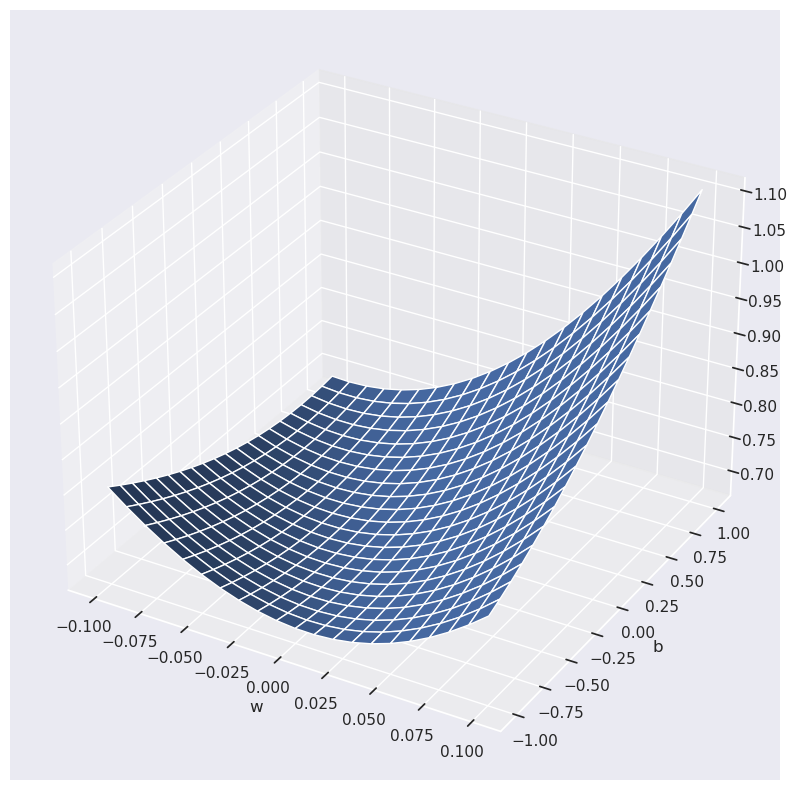

In [14]:
# Plotting the cost function against model parameters
from mpl_toolkits.mplot3d import Axes3D
w, b = np.meshgrid(np.linspace(-0.1, 0.1, 21), np.linspace(-1, 1, 21))
X = np.array([1.56, 0.76 , 0.08, 9.71, 4.65, 4.35, 7.34, 0.91, 9.82, 9.05]).reshape((10, 1))
y = np.array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])
cost = np.array([[cost_logreg_vec(X, y, np.array([w0]), b0) for b0 in b[:, 0]] for w0 in w[0]])
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')
ax.plot_surface(w, b, cost)
ax.set(xlabel = "w", ylabel = "b")

The prediction $y'$ in $(1)$ can be converted to a decision by using a threshold value. For instance, suppose we take the threshold to be $0.5$. Then, we may classify the observation to class $1$ if $y' \geq 0.5$, and to class $0$ otherwise. The problem, however, is that we do not know the model parameters $\mathbf{w}$ and $b$, and hence cannot compute $y'$ directly. First, we have to fit the model by finding the best fitting parameters. Observe that, given the training data, $C\left(\mathbf{y}, \mathbf{y'}\right)$ depends on $\mathbf{w}$ and $b$ only. A reasonable strategy, therefore, is:

$$ \text{To minimise } J\left(\mathbf{w}, b\right), \text{ with respect to } \mathbf{w} \text{ and } b. $$

We shall employ the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) [algorithm](https://en.wikipedia.org/wiki/Algorithm) to solve this [optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) problem.

# Gradient Descent


**The algorithm.** In the context of minimising the cost function $J$, with respect to the model parameters $\mathbf{w}$ and $b$, the gradient descent algorithm is given by:

$$ \begin{align*}
& \text{repeat until convergence:}\; \{ \newline
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j},\; \text{ for } j = 1, 2, \ldots, n; \newline
& b := b -  \alpha \frac{\partial J(\mathbf{w}, b)}{\partial b}. \tag{4} \newline
& \}
\end{align*} $$

where $\alpha$ is the [learning rate](https://en.wikipedia.org/wiki/Learning_rate), and the parameters $\mathbf{w} = (w_1, w_2, \cdots, w_n)$ and $b$ are updated simultaniously in each iteration.

**Computing gradient.** Before we can implement the gradient descent algorithm, we need to compute the gradients first! From $(3)$, we can compute the partial derivatives of $J$ with respect to $w_j$ and $b$ as follows:

$$ \begin{align*}
& \frac{\partial J(\mathbf{w},b)}{\partial w_j} = \frac{1}{m} \sum\limits_{i = 1}^m \left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}} - y_i\right) x_{i,j},\;\; \text{ for } j = 1, 2, \ldots, n; \newline
& \frac{\partial J(\mathbf{w}, b)}{\partial b} = \frac{1}{m} \sum\limits_{i = 1}^m \left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}} - y_i\right).
\end{align*} $$

The next code blocks construct a function to compute these gradients, first using for loops, then using vectorization.

In [15]:
# Function to compute gradients of the cost function with respect to model parameters - using for loops
def grad_logreg(X, y, w, b):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = np.zeros(n), 0
    for i in range(m):
        s = 0
        for j in range(n):
            s += X[i, j] * w[j]
        y_dash_i = logistic(s + b)
        for j in range(n):
            grad_w[j] += (y_dash_i  - y[i]) * X[i,j]
        grad_b += y_dash_i  - y[i]
    grad_w, grad_b = grad_w / m, grad_b / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg(X, y, w, b)}")

grad_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), np.float64(0.4999916492890759))


In [16]:
# Function to compute gradients of the cost function with respect to model parameters - using vectorization
def grad_logreg_vec(X, y, w, b): 
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    y_dash = logistic(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg_vec(X, y, w, b)}")

grad_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), np.float64(0.4999916492890759))


Armed with the required functions, we can now implement the gradient descent algorithm, given in $(4)$. 

In [17]:
# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      cost_func                 : function to compute cost
      grad_func                 : function to compute gradients of cost with respect to model parameters
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history

X, y, w, b, alpha, n_iter = np.array([[0.1, 0.2], [-0.1, 0.1]]), np.array([1, 0]), np.array([0., 0.]), 0., 0.1, 100000
w_out, b_out, cost_history, params_history = grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = True)

  5%|▍         | 4695/100000 [00:00<00:05, 16926.54it/s]

Iteration      0:    Cost  0.6928,    Params  [array([0.005 , 0.0025]), np.float64(0.0)]


 14%|█▍        | 14307/100000 [00:00<00:04, 18534.09it/s]

Iteration  10000:    Cost  0.0867,    Params  [array([19.30073125,  9.43918518]), np.float64(-1.4078696585361676)]


 23%|██▎       | 22744/100000 [00:01<00:05, 13478.40it/s]

Iteration  20000:    Cost  0.0430,    Params  [array([25.11290735, 12.28127422]), np.float64(-1.8345297190719223)]


 32%|███▏      | 31584/100000 [00:02<00:05, 11903.23it/s]

Iteration  30000:    Cost  0.0283,    Params  [array([28.51960605, 13.947125  ]), np.float64(-2.084520137444322)]


 42%|████▏     | 41593/100000 [00:02<00:03, 15368.34it/s]

Iteration  40000:    Cost  0.0211,    Params  [array([30.9258698 , 15.12377399]), np.float64(-2.261072754000601)]


 54%|█████▍    | 53803/100000 [00:03<00:03, 14511.65it/s]

Iteration  50000:    Cost  0.0168,    Params  [array([32.78441957, 16.03259549]), np.float64(-2.397428663482232)]


 63%|██████▎   | 63145/100000 [00:04<00:03, 12022.78it/s]

Iteration  60000:    Cost  0.0139,    Params  [array([34.29765304, 16.77255979]), np.float64(-2.5084448658725664)]


 73%|███████▎  | 73080/100000 [00:05<00:01, 13708.64it/s]

Iteration  70000:    Cost  0.0119,    Params  [array([35.57340822, 17.39639871]), np.float64(-2.602035975617821)]


 84%|████████▎ | 83586/100000 [00:06<00:01, 12966.24it/s]

Iteration  80000:    Cost  0.0104,    Params  [array([36.67589743, 17.93551157]), np.float64(-2.682914282617459)]


 91%|█████████▏| 91492/100000 [00:06<00:00, 14091.52it/s]

Iteration  90000:    Cost  0.0092,    Params  [array([37.64642667, 18.4100967 ]), np.float64(-2.7541108549220774)]


100%|██████████| 100000/100000 [00:07<00:00, 13475.25it/s]

Iteration  99999:    Cost  0.0083,    Params  [array([38.51304248, 18.83386869]), np.float64(-2.8176836626325836)]


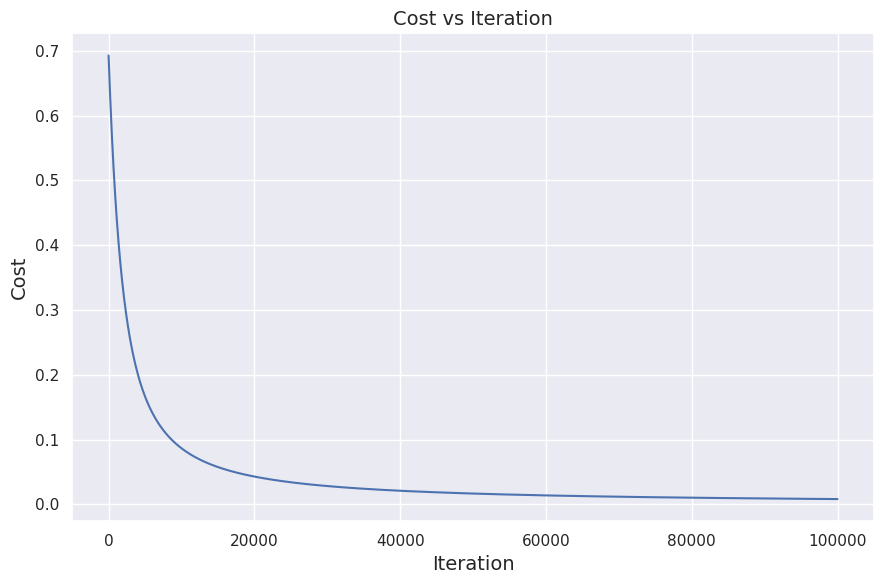

In [18]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
!wget "https://github.com/adityamoorthy2/Datasets_for_Summer_School/blob/main/apple-orange-dataset.csv?raw=true" -O apple-orange-dataset.csv

data = pd.read_csv('apple-orange-dataset.csv')

y = data['label']

features = ['weight','diameter']
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=2)

In [21]:
data.head()

,label,weight,diameter
0,1,136,10.557432
1,1,192,11.292246
2,1,112,10.120368
3,1,185,8.786955
4,1,129,10.070343


In [22]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

We normalize the data, so that each column has values in the similar scale.

In [23]:
# Min-Max normalization
for col in X_train.columns:
    if (X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64') and X_train[col].nunique() > 1:
        X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())
for col in X_test.columns:
    if (X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64') and X_test[col].nunique() > 1:
        X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

In [24]:
X_train.head()

,weight,diameter
212,0.41250,0.224904
259,0.31250,0.603419
126,0.71875,0.342896
127,0.68125,0.317064
178,0.68750,0.329301


# Model Fitting

We fix the initial values of the parameters, based on running the algorithm several times and noting down the final parameter values. It gives us a better *starting point* and helps to achieve a better performance in a limited number of iterations.

In [25]:
# Initial values of the model parameters
w_init = np.array([0,0]).astype(float)
b_init = 0

In [26]:
# Learning model parameters using gradient descent algorithm
w_out, b_out, cost_history, params_history = grad_desc(X_train.to_numpy(),
                                                       y_train.to_numpy(),
                                                       w = w_init, # np.zeros(X_train.shape[1]),
                                                       b = b_init, # 0,
                                                       alpha = 0.1,
                                                       n_iter = 2000)

 17%|█▋        | 346/2000 [00:00<00:01, 1166.05it/s]

Iteration      0:    Cost  0.6920
Iteration    200:    Cost  0.5529
Iteration    400:    Cost  0.4667


 48%|████▊     | 954/2000 [00:00<00:00, 1213.54it/s]

Iteration    600:    Cost  0.4089
Iteration    800:    Cost  0.3683
Iteration   1000:    Cost  0.3384


 67%|██████▋   | 1337/2000 [00:01<00:00, 1211.15it/s]

Iteration   1200:    Cost  0.3158
Iteration   1400:    Cost  0.2981


 99%|█████████▉| 1988/2000 [00:01<00:00, 1234.34it/s]

Iteration   1600:    Cost  0.2840
Iteration   1800:    Cost  0.2725


100%|██████████| 2000/2000 [00:01<00:00, 1213.55it/s]

Iteration   1999:    Cost  0.2631


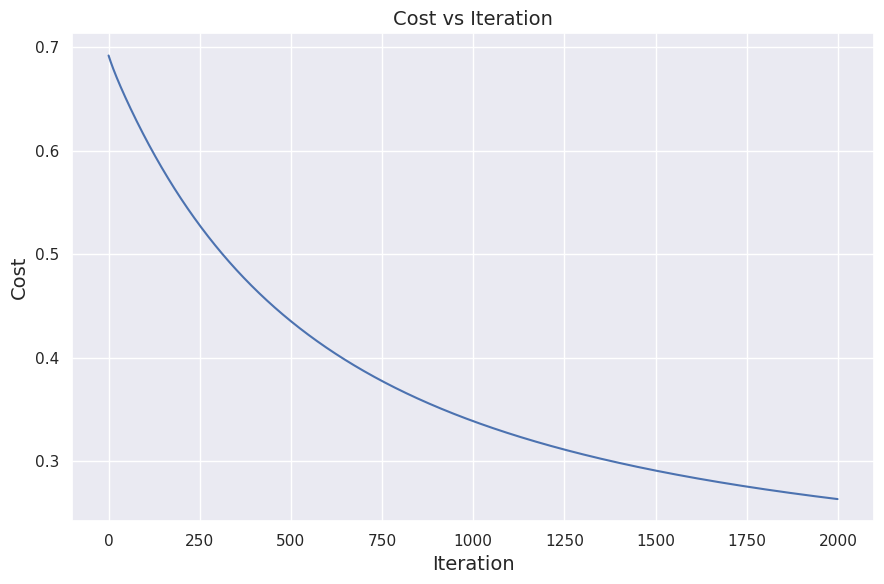

In [27]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [28]:
# Final parameter values
params_history[-1]

[array([ 6.18198232, -5.68073286]), np.float64(-0.3350697444276029)]

# Prediction and Evaluation

First, we construct some functions to compute and display the *confusion matrix*, and to compute *accuracy*, given the true labels and the predicted labels of the target.

In [29]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [30]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [31]:
# Function to compute accuracy
def accuracy(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      acc (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    num = confusion_mat[0, 0] + confusion_mat[1, 1] # Number of correct predictions
    denom = num + confusion_mat[0, 1] + confusion_mat[1, 0] # Number of total predictions
    acc = num / denom
    return acc

In [32]:
# Prediction and evaluation on the training set and the test set
y_train_prob = logistic(np.matmul(X_train.to_numpy(), w_out) + (b_out * np.ones(X_train.shape[0])))
y_test_prob = logistic(np.matmul(X_test.to_numpy(), w_out) + (b_out * np.ones(X_test.shape[0])))
y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred),
                 "Test accuracy": accuracy(y_test, y_test_pred)}).to_string())

Training accuracy    0.936255
Test accuracy        0.934524


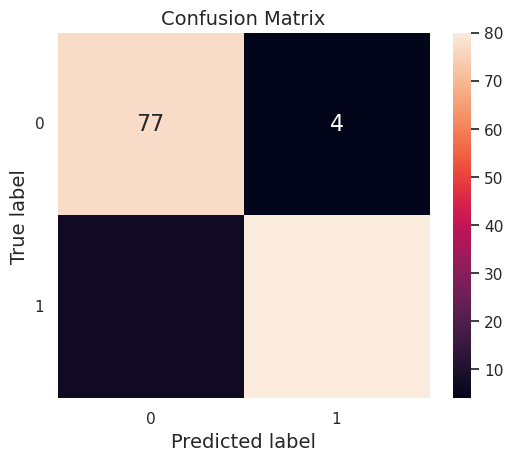

In [33]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred)